# Test data trajectory analysis

To generate synthetic sequences we need "paths" that control the movement of the object in the scene. The most obvious source for a generative model for "natural" paths are the test sequences inside the tracking datasets. 

The are many ways to analyze this data. We will try some of these alternatives, starting by a mapping to our synthetic generation model i.e. 5 degrees of freedom (DOF) corresponding to rotation, scaling and translation. The first point analyzed was that as the ground truth bounding boxes are axis-aligned, it is difficult to infer rotation information directly from the box. Therefore, our first visualizations belong to only scaling and translation transformations i.e. 4 DOF.

## Modeling the transformation

Our transformation model is composed of a scaling ($ S(s_{x},s_{y}) $), followed by rotation ($ R( \theta ) $) and finally translation ($ T(t_{x}, t_{y}) $), resulting in a single transform 
$$ T_{full}(\theta, s_{x}, s_{y}, t_{x}, t_{y}) = T(t_{x}, t_{y})*R( \theta )*S(s_{x},s_{y}) $$
$$ T_{full}(\theta, s_{x}, s_{y}, t_{x}, t_{y}) = \begin{bmatrix} 1 & 0 & t_{x} \\ 0 & 1 & t_{y} \\ 0 & 0 & 1 \end{bmatrix} * \begin{bmatrix} cos(\theta) & sin(\theta) & 0 \\ -sin(\theta) & cos(\theta) & 0 \\ 0 & 0 & 1 \end{bmatrix} * \begin{bmatrix} s_{x} & 0 & 0 \\ 0 & s_{y} & 0 \\ 0 & 0 & 1 \end{bmatrix} $$

$$ T_{full}(\theta, s_{x}, s_{y}, t_{x}, t_{y}) = \begin{bmatrix} s_{x}*cos(\theta) & s_{y}*sin(\theta) & t_{x} \\ -s_{x}*sin(\theta) & s_{y}*cos(\theta) & t_{y} \\ 0 & 0 & 1 \end{bmatrix} $$


All this transformations are referenced to the scene coordinates, which has its origin at the top-left corner and increase towards the bottom-right corner.

In [1]:
import sympy

In [2]:
th = sympy.symbols('theta')
sx = sympy.symbols('sx')
sy = sympy.symbols('sy')
tx = sympy.symbols('tx')
ty = sympy.symbols('ty')
t00 = sympy.symbols('t00')
t01 = sympy.symbols('t01')
t02 = sympy.symbols('t02')
t10 = sympy.symbols('t10')
t11 = sympy.symbols('t11')
t12 = sympy.symbols('t12')

In [3]:
T = sympy.Matrix([[1, 0, tx],[0,1,ty],[0,0,1]])

In [4]:
S = sympy.Matrix([[sx, 0, 0],[0,sy,0],[0,0,1]])

In [5]:
R = sympy.Matrix([[sympy.cos(th), sympy.sin(th), 0],[-sympy.sin(th),sympy.cos(th),0],[0,0,1]])

In [6]:
Tfull = T*R*S

In [7]:
Tsolved = sympy.Matrix([[t00,t01,t02],[t10,t11,t12],[0,0,1]])

In [8]:
Tfull

Matrix([
[ sx*cos(theta), sy*sin(theta), tx],
[-sx*sin(theta), sy*cos(theta), ty],
[             0,             0,  1]])

In [9]:
product = sympy.simplify(sympy.det(Tfull))

In [10]:
product

sx*sy

In [11]:
sympy.simplify(sympy.det(Tsolved))

t00*t11 - t01*t10

In [12]:
ratio = Tfull[0,0]/Tfull[1,1]

In [13]:
ratio

sx/sy

In [14]:
product*ratio

sx**2

In [15]:
Tsolved[0,0]/Tsolved[1,1]

t00/t11

In [16]:
product/ratio

sy**2

In [17]:
sympy.simplify(sympy.atan2(Tfull[0,1],Tfull[0,0]))

atan2(sy*sin(theta), sx*cos(theta))

In order to model the parameters of this transformation, we must first obtain the actual values of the transformation from the ground truth bounding boxes, and then solve the parameters by equating the real transform with the symbolic form stated above.

## Obtaining the transformation matrix

The transformation may be obtained from the points by taking into account that the transformation is the way to project points from one coordinate system to another. 
$$ P^{s}=T_{full}*P^{o} $$
The equation may be stated as "the points in the scene coordinate system are obtained by applying $ T_{full} $ on the points in the object coordinate system"
The unknown here is the transform $ T_{full} $, and the known variables are the points in the scene and object coordinate systems. An affine transform has 6 degrees of freedom (DOF) an therefore 6 independent variables to solve, our transformation has only 5 DOF. The number of DOF is related to the number of points or equations required to solve the transformation matrix. In our case, we are using an overdetermined system, as we are using the 8 coordinates of the 4 bounding box points to find the transformation matrix, which generates 8 equations but only 5 are needed. Nevertheless, the transformation obtained is correct, as the non-colinearity of at least 3 points is satisfyied.

The linear system to solve is then given by
$$ \begin{bmatrix} x_{0}^{s} & ... & x_{n}^{s} \\ y_{0}^{s} & ... & y_{n}^{s} \\ 1 & ... & 1 \end{bmatrix} = T_{full} * \begin{bmatrix} x_{0}^{o} & ... & x_{n}^{o} \\ y_{0}^{o} & ... & y_{n}^{o} \\ 1 & ... & 1 \end{bmatrix}$$
where $ n $ is the number of points available and must satisfy $ n \geq \# DOF $.
The solution is then
$$ T_{full} = \begin{bmatrix} x_{0}^{s} & ... & x_{n}^{s} \\ y_{0}^{s} & ... & y_{n}^{s} \\ 1 & ... & 1 \end{bmatrix} * \begin{bmatrix} x_{0}^{o} & ... & x_{n}^{o} \\ y_{0}^{o} & ... & y_{n}^{o} \\ 1 & ... & 1 \end{bmatrix}^{-1} $$
where the pseudo-inverse may be applied as the matrices used are in general not square.

When the initial box was transformed according to the numerical transformation matrix $ T_{full} $ the box followed correctly the ground truth.

## Solving for the parameters

Now that we have the transformation matrix, we equate it to the previously defined transformation model

$$ T_{full}(\theta, s_{x}, s_{y}, t_{x}, t_{y}) = \begin{bmatrix} s_{x}*cos(\theta) & s_{y}*sin(\theta) & t_{x} \\ -s_{x}*sin(\theta) & s_{y}*cos(\theta) & t_{y} \\ 0 & 0 & 1 \end{bmatrix} = \begin{bmatrix} x_{0}^{s} & ... & x_{n}^{s} \\ y_{0}^{s} & ... & y_{n}^{s} \\ 1 & ... & 1 \end{bmatrix} * \begin{bmatrix} x_{0}^{o} & ... & x_{n}^{o} \\ y_{0}^{o} & ... & y_{n}^{o} \\ 1 & ... & 1 \end{bmatrix}^{-1} = \begin{bmatrix} t_{0,0} & t_{0,1} & t_{0,2} \\ t_{1,0} & t_{1,1} & t_{1,2} \\ t_{2,0} & t_{2,1} & t_{2,2} \end{bmatrix}$$

where $ t_{2,i} $ need not be solved as they are 0,0, and 1

### Translation parameters

The transformation model and order was selected to obtain a simple and almost decoupled transformation model, where the parameters were easy to solve and analyze. That is evident in the solution of the translation parameters, which correspond directly to the first and second elements of the third column of the real transformation. 
$$ t_{x} = t_{0,2},\space t_{y} = t_{1,2} $$

### Scaling parameters

The scaling and rotation parameters need a more involved solution. An equation omitting the rotation parameter may be obtained by using the trigonometric identity 
$$ coṣ^{2}(\theta)+sin^{2}(\theta)=1$$
which is found by taking the determinant of the matrix over the element $ t_{2,2} $
$$ t_{2,2}*(t_{0,0}*t_{1,1}-t_{0,1}*t_{1,0}) = 1*(s_{x}*cos(\theta)*s_{y}*cos(\theta)-[-s_{x}*sin(\theta)*s_{y}*sin(\theta)]) $$
$$ t_{2,2}*(t_{0,0}*t_{1,1}-t_{0,1}*t_{1,0}) = s_{x}*s_{y}*(coṣ^{2}(\theta)+sin^{2}(\theta)) $$
$$ t_{2,2}*(t_{0,0}*t_{1,1}-t_{0,1}*t_{1,0})= s_{x}*s_{y} $$
The other equation is obtained by a quotient of the diagonal of the upper left 2 by 2 matrix
$$ \frac{s_{x}*cos(\theta)}{s_{y}*cos(\theta)} = \frac{s_{x}}{s_{y}} = \frac{t_{0,0}}{t_{1,1}} $$

### Rotation parameter

The rotation parameter is obtained by using the $ atan2 $ function of the diagonal elements
$$ \theta_{PV} = atan2(sy*sin(\theta), sy*cos(\theta)) = atan2(t_{0,1}, t_{1,1})$$
The $ atan2 $ function has a range of $ [-\pi, \pi] $, but we want to model continuous rotations, so we solve for the periodic relation
$$ \theta = \theta_{PV}+n*\pi | n\in\cal{Z} $$
and choose the $ n $ that generates the closest angle to the angle in the previous frame.

In [18]:
%pylab inline --no-import-all

Populating the interactive namespace from numpy and matplotlib


In [19]:
from PIL import Image, ImageDraw
import numpy
import os
import matplotlib
import matplotlib.pyplot
import IPython.display
import animator
import pickle
import time

In [20]:
#Helper functions

def read_gt(gtPath):
    '''Reads the ground truth from a file and returns a list of bounding boxes'''
    gtFile = open(gtPath, 'r')
    lines = gtFile.xreadlines()
    #TODO: better replacement of whitespace
    gt = [map(float, line.strip().replace(',', ' ').split()) for line in lines]
    gtFile.close()
    return gt

In [21]:
def draw_polygon(imagePath, polygons, outlines=['red', 'green', 'blue']):
    '''Draws polygons on an image and shows the numbering of the points'''
    image = Image.open(imagePath)
    draw = ImageDraw.ImageDraw(image)
    for id, polygon in enumerate(polygons):
        draw.polygon(polygon, outline=outlines[id])
        for i in range(len(polygon)/2):
            draw.text(polygon[2*i:2*i+2], str(i), fill=outlines[id])
    return image

In [22]:
def homogeneous_points(coordinates, dims=2):
    '''Converts a flat point list to a column stacked point array in homogeneous coordinates'''
    values = numpy.reshape(coordinates, (len(coordinates)/2, dims)).T
    points = numpy.vstack([values, numpy.ones((1, values.shape[1]))])
    return points

In [23]:
#NOTE: Depends on transformation order: T*S*R
def transform_params(transform, prevAngle=None):
    '''Returns the parameters for a T*S*R decomposition of the transform matrix'''
    x = transform[0,-1]
    y = transform[1,-1]
    originalTheta = numpy.arctan2(transform[0,1],transform[1,1])
    theta = originalTheta
    if prevAngle is not None:
        n = numpy.around((prevAngle - theta)/numpy.pi)
        theta += n*numpy.pi
    ratio = transform[0,0]/transform[1,1] if numpy.abs(numpy.cos(theta))>=numpy.abs(numpy.sin(theta)) else -transform[1,0]/transform[0,1]
    product = transform[0,0]*transform[1,1]-transform[0,1]*transform[1,0]
    sx = numpy.sqrt(product*ratio)
    sy = numpy.sqrt(product/ratio)
    return x,y,sx,sy,theta,originalTheta, product, ratio

In [24]:
def show_boxes(gtPath, gt):
    '''Plots overlaid bounding boxes'''
    frameSize = Image.open(os.path.join(os.path.dirname(gtPath), '00000001.jpg')).size
    image = Image.new('RGBA', frameSize)
    canvas = ImageDraw.ImageDraw(image)
    for box in gt:
        canvas.polygon(box)
    matplotlib.pyplot.imshow(numpy.asarray(image))

In [25]:
def box_video(output, gtPath, boxData, *args, **kwargs):
    '''Generates a video of the sequence with bounding boxes overlaid'''
    sequence = (
        draw_polygon(
            os.path.join(os.path.dirname(gtPath), imagePath),
            [boxes[i] for boxes in boxData]
        )
        for i, imagePath in 
        enumerate(sorted(os.listdir(os.path.dirname(gtPath)))[1:])
        if imagePath.endswith('.jpg')
    )
    animator.frames2video(sequence, 30, output, *args, **kwargs)
    videoSrc = 'data:video/mp4;base64,' + open(output, 'rb').read().encode('base64')
    videoTag = '<video controls width="320" height="240"><source src="{0}" type="video/mp4">Unsupported tag</video>'
    return videoTag.format(videoSrc)

In [26]:
def analyze_sequence(gtPath, gt, relative=False, *args, **kwargs):
    #The first box is used as the reference location of the object
    refPoints = homogeneous_points(gt[0])
    predictedPointsList = []
    transformedPointsList = []
    #Reference points are moved to the origin
    #TODO: min coordinates may come from different points
    refPoints = refPoints-numpy.array([[numpy.min(refPoints[0,:]), numpy.min(refPoints[1,:]), 0]]).T
    #Placeholder for parameters, dynamic rows
    path = numpy.empty((0,8))
    diffs = []
    averageDiff = 0
    previousTheta = None
    gtThetas = []
    #Relative transform makes us loose the initial transform
    if relative:
        rangeStart = 1
    else:
        rangeStart = 0
    for i in range(rangeStart,len(gt)):
        points = homogeneous_points(gt[i])
        transform = numpy.dot(points, numpy.linalg.pinv(refPoints))
        transformedPoints = numpy.dot(transform, refPoints)
        transformedPointsList.append(transformedPoints[:2,:].T.flatten())
        params = transform_params(transform, prevAngle=previousTheta)
        path = numpy.vstack([path, params])
        tx, ty, sx, sy, theta, originalTheta, product, ratio = params
        gtTheta = numpy.arctan2(transformedPoints[1,2]-transformedPoints[1,1], transformedPoints[0,2]-transformedPoints[0,1])
        gtThetas.append(gtTheta)
        #theta = -gtTheta
        previousTheta = theta
        predictedTransform = numpy.array([[sx*numpy.cos(theta), sy*numpy.sin(theta), tx],[-sx*numpy.sin(theta), sy*numpy.cos(theta), ty],[0,0,1]])
        predictedPoints = numpy.dot(predictedTransform, refPoints)
        predictedPointsList.append(predictedPoints[:2,:].T.flatten())
        currentDiff = numpy.linalg.norm(transform[:2,:]-predictedTransform[:2,:])
        diffs.append(currentDiff)
        averageDiff += currentDiff
        #Update ref points to previous box and obtain a intraframe relative transform
        if relative:
            refPoints = points
    averageDiff /= len(gt)
    print 'Average difference for sequence {}: {}'.format(gtPath, averageDiff)
    return gtThetas, path[:,:4], transformedPointsList, predictedPointsList

def visualize_sequence(gtPath, gt, relative=False, video=False, output='/tmp/visualization.mp4', *args, **kwargs):
    retVal = ''
    #matplotlib.pyplot.figure()
    #show_boxes(gtPath, gt)
    
    gtThetas, path, transformedPointsList, predictedPointsList = analyze_sequence(gtPath, gt, relative)
    #matplotlib.pyplot.figure()
    #matplotlib.pyplot.plot(gtThetas, label='GT angle')
    #matplotlib.pyplot.plot(-path[:,5], '.', label='Solved angle')
    #matplotlib.pyplot.title(os.path.split(os.path.dirname(gtPath))[-1])
    #matplotlib.pyplot.legend()
    
    boxGt = numpy.asarray(gt)[:,[0,1,4,5]]
    stackedParametrizations = numpy.hstack([path,boxGt])#[:, [2,3,6,7]]
    
    #titles = ['$ tx $', '$ ty $', '$ sx $', '$ sy $', '$ \\theta $', '$ \\theta_{pv}$', 'product', 'ratio']
    titles = ['$ tx $', '$ ty $', '$ sx $', '$ sy $', '$ x_{0} $', '$ y_{0} $', '$ x_{2} $', '$ y_{2} $']
    matplotlib.pyplot.figure()
    matplotlib.pyplot.gcf().subplots_adjust(bottom=0.0, hspace=0.0)
    print 'Stacked parametrizations shape: {} Box gt shape: {} Path shape: {}'.format(stackedParametrizations.shape, boxGt.shape, path.shape)
    
    for i in range(stackedParametrizations.shape[1]):
        axes = matplotlib.pyplot.subplot(1,stackedParametrizations.shape[1],i+1)
        matplotlib.pyplot.plot(stackedParametrizations[:,i])
        #if i < stackedParametrizations.shape[1]-1:
        #    matplotlib.pyplot.setp( axes.get_xticklabels(), visible=False)
        matplotlib.pyplot.setp( axes.get_xticklabels(), visible=False)
        matplotlib.pyplot.ylabel(titles[i])
    matplotlib.pyplot.title(os.path.split(os.path.dirname(gtPath))[-1])
        
    if video:
        rangeStart = 0
        if relative:
            rangeStart = 1
        retVal += box_video(output, gtPath,\
                    [gt[rangeStart:], [point.tolist() for point in transformedPointsList], [point.tolist() for point in predictedPointsList]],\
                    *args, **kwargs)
    
    return retVal, path

In [27]:
seqDir = '/home/fmpaezri/datasets/tracker_benchmark/sequences/'

Average difference for sequence /home/fmpaezri/datasets/tracker_benchmark/sequences/Basketball/groundtruth.txt: 2.52380177387e-15
Stacked parametrizations shape: (725, 8) Box gt shape: (725, 4) Path shape: (725, 4)
Average difference for sequence /home/fmpaezri/datasets/tracker_benchmark/sequences/Bolt/groundtruth.txt: 7.04769576032e-15
Stacked parametrizations shape: (350, 8) Box gt shape: (350, 4) Path shape: (350, 4)
Average difference for sequence /home/fmpaezri/datasets/tracker_benchmark/sequences/Boy/groundtruth.txt: 4.76857331977e-15
Stacked parametrizations shape: (602, 8) Box gt shape: (602, 4) Path shape: (602, 4)
Average difference for sequence /home/fmpaezri/datasets/tracker_benchmark/sequences/Car4/groundtruth.txt: 8.01392350757e-16
Stacked parametrizations shape: (659, 8) Box gt shape: (659, 4) Path shape: (659, 4)
Average difference for sequence /home/fmpaezri/datasets/tracker_benchmark/sequences/CarDark/groundtruth.txt: 3.41892044157e-15
Stacked parametrizations shape: 

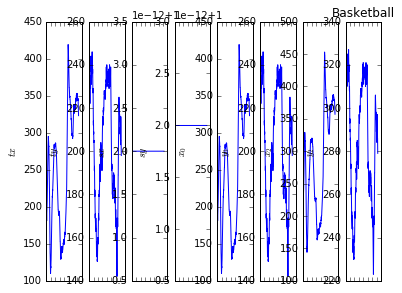

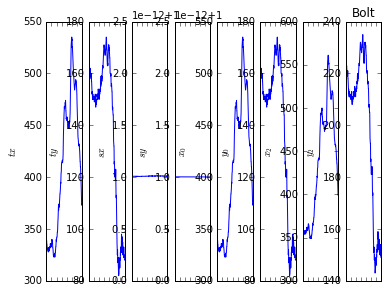

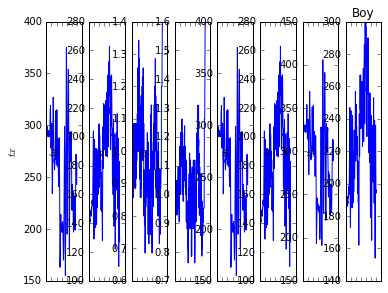

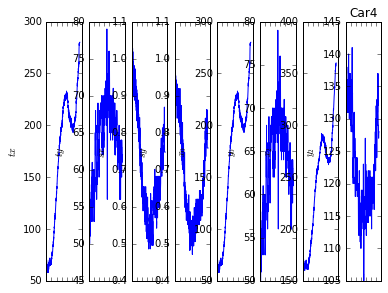

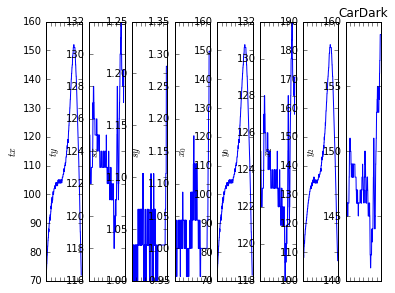

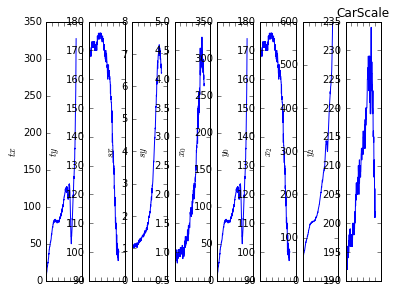

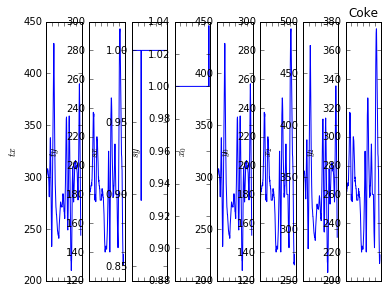

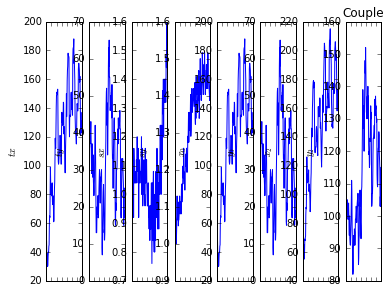

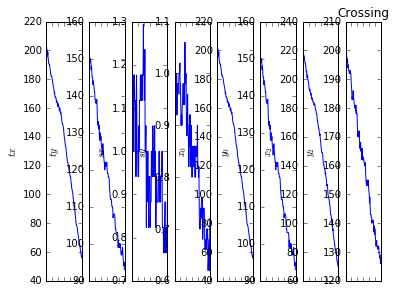

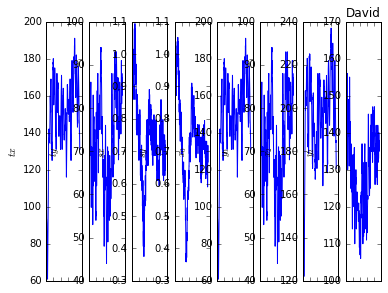

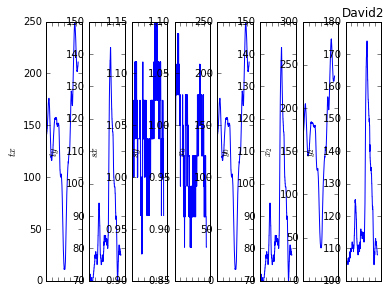

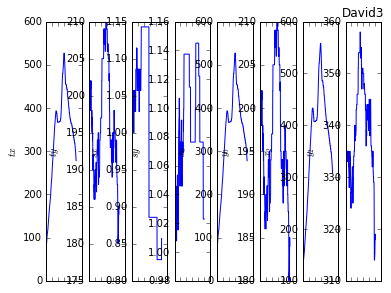

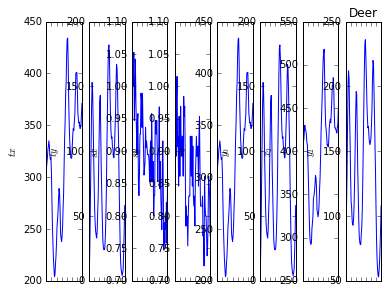

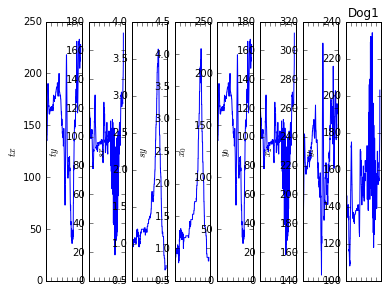

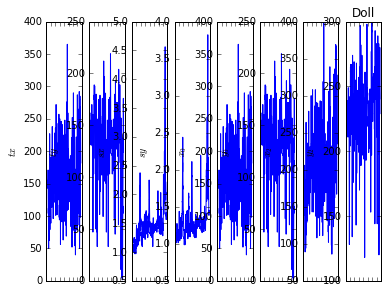

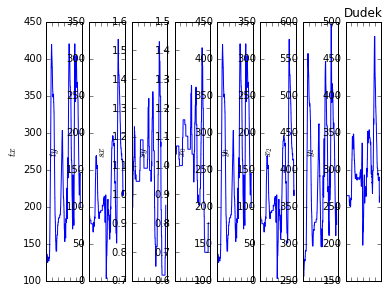

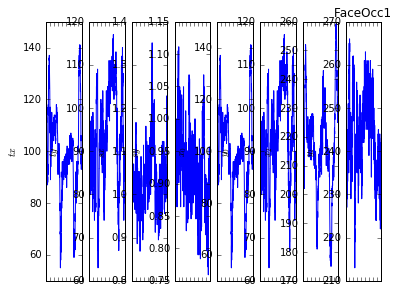

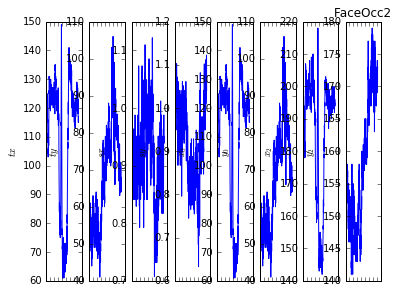

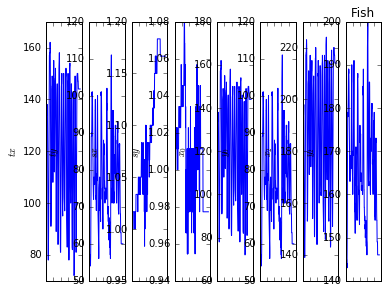

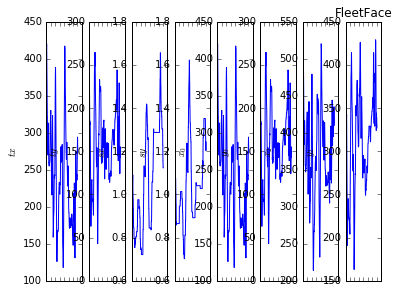

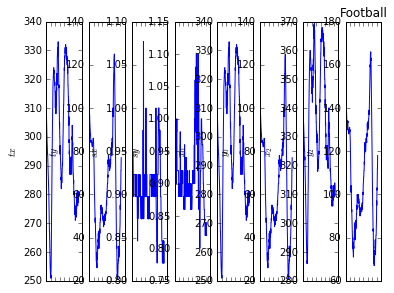

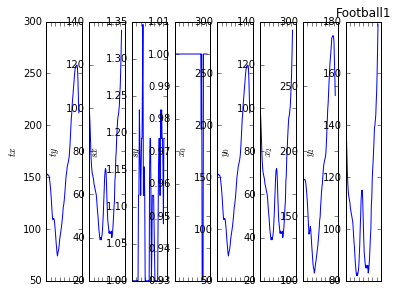

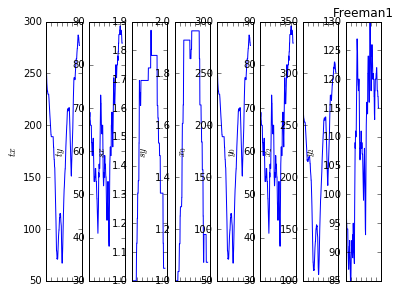

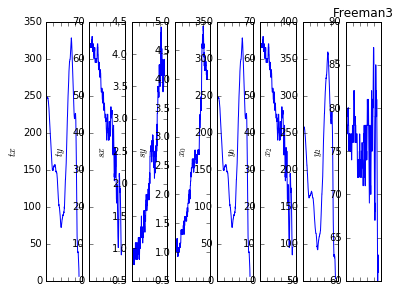

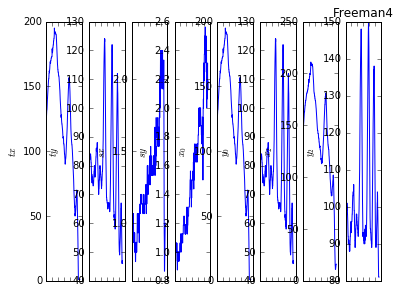

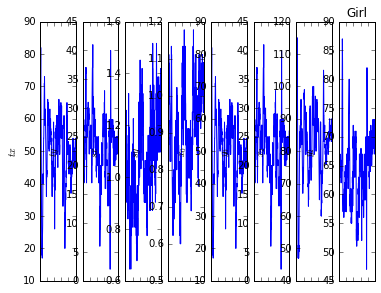

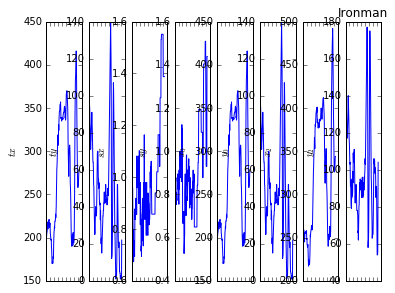

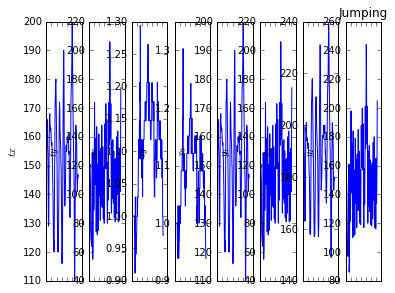

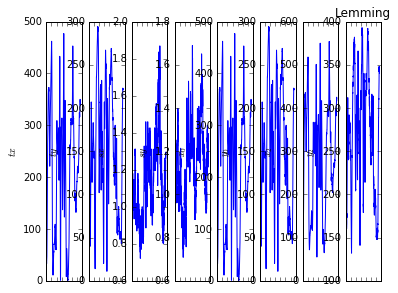

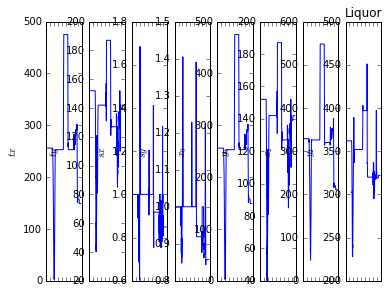

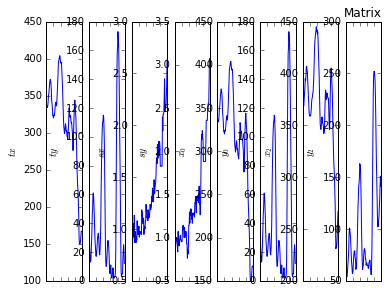

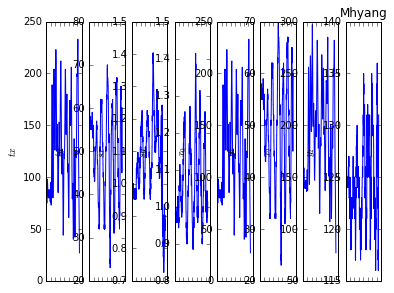

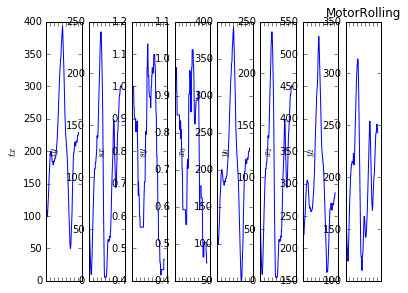

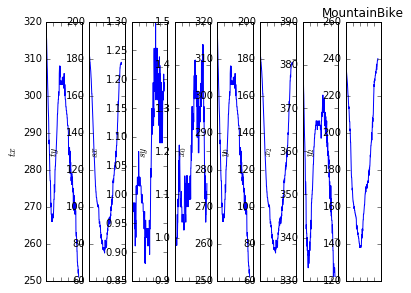

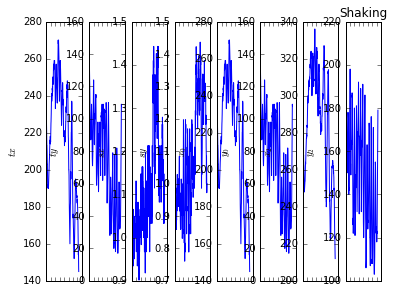

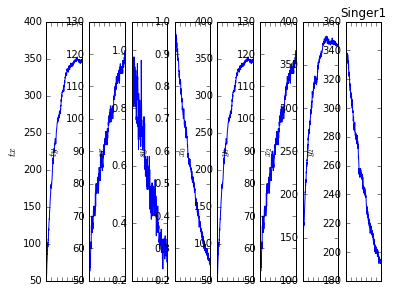

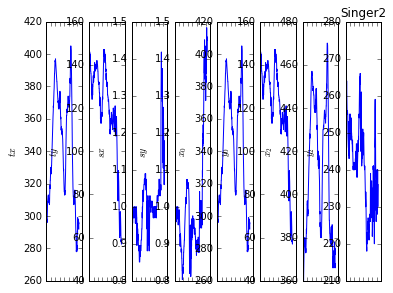

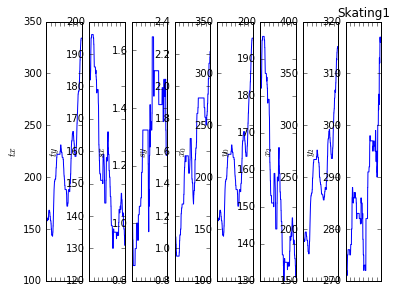

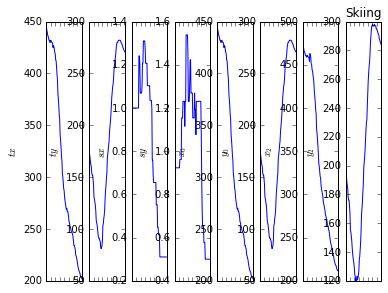

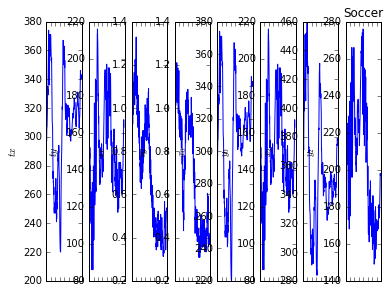

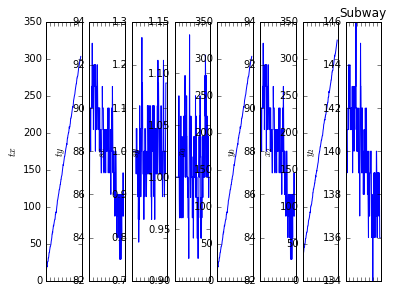

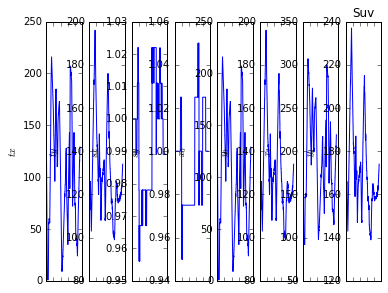

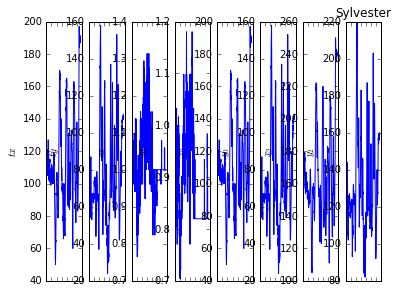

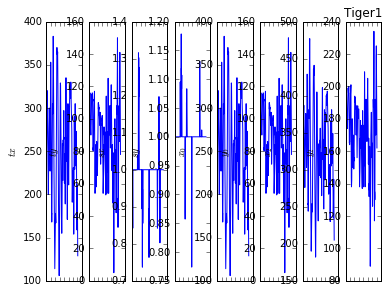

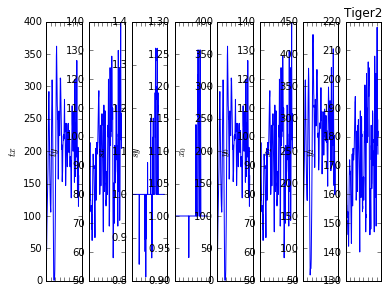

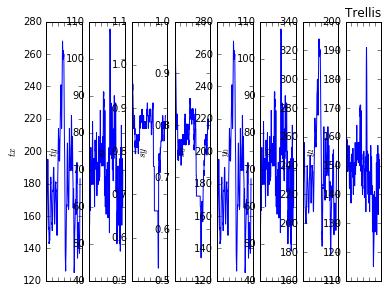

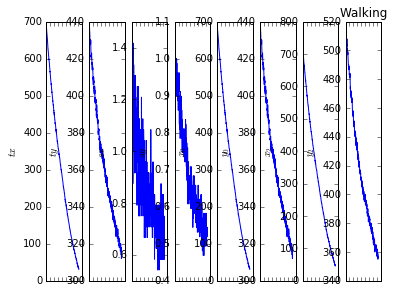

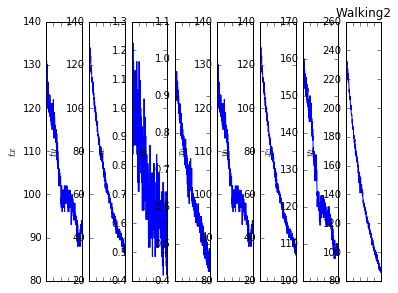

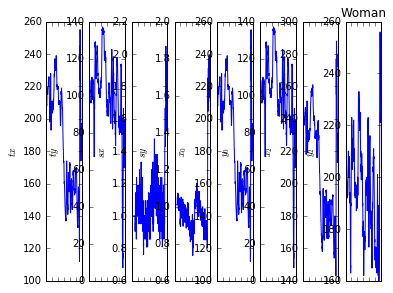

In [38]:
pathDict = {}
startTime = time.time()
for aSequence in sorted(os.listdir(seqDir)):
    currentDir = os.path.join(seqDir, aSequence)
    if not os.path.isdir(currentDir):
        continue
    gtPath = '{}/groundtruth.txt'.format(currentDir)
    gt = read_gt(gtPath)
    html, path = visualize_sequence(gtPath, gt, relative=False)
    pathDict[aSequence] = path
endTime = time.time()
print 'Elapsed time: {}'.format(endTime-startTime)
#pathFile = open('relativeTrajectoryParamsOOT.pkl', 'w')
#pickle.dump(pathDict, pathFile)
#pathFile.close()

Average difference for sequence /home/fmpaezri/datasets/tracker_benchmark/sequences/Walking/groundtruth.txt: 3.22661166106e-15


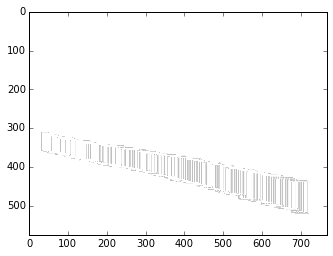

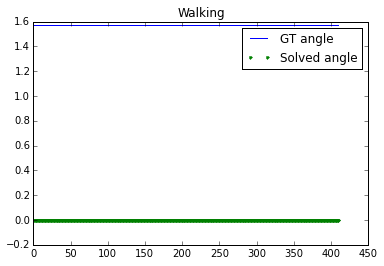

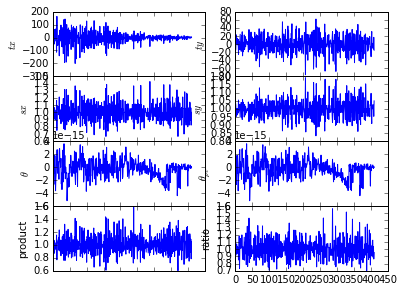

In [42]:
gtPath = '{}/groundtruth.txt'.format(os.path.join(seqDir, 'Walking'))
html, path = visualize_sequence(gtPath, read_gt(gtPath), relative=True, video=True, piped=False)
IPython.display.HTML(html)

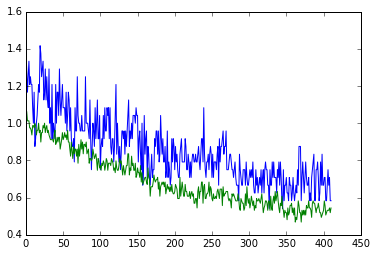

In [43]:
matplotlib.pyplot.plot(numpy.cumprod(path[:,2:4], axis=0))

Average difference for sequence /home/fmpaezri/datasets/tracker_benchmark/sequences/Walking/groundtruth.txt: 1.76418738733e-15


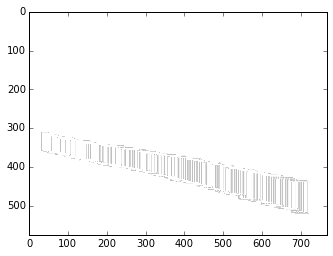

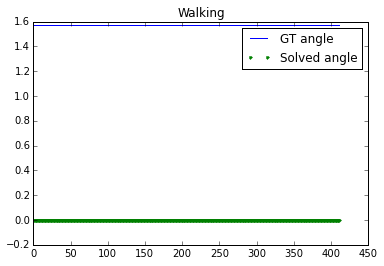

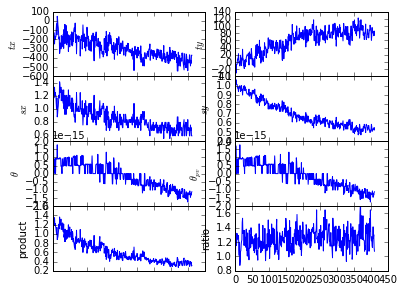

In [45]:
gtPath = '{}/groundtruth.txt'.format(os.path.join(seqDir, 'Walking'))
html, path = visualize_sequence(gtPath, read_gt(gtPath), relative=False, video=True, piped=False)
IPython.display.HTML(html)